# Machine Learning | Assignment 2

## Retireving and Preparing the Data

### Importing Libraries 

In [1]:
import pandas as pd

### About this dataset

The dataset consists of 27x27 RGB images of colon cells
from 99 different patients.
The purpose is to classify and identify whether given cell image represents a cancerous cells or not (isCancerous).
And to classify cell-type, such as: fibroblast, inflammatory,
epithelial or others.


## Loading the Image Classification Data set

In [2]:
dataLabelsFrame = pd.read_csv ('Image_classification_data\data_labels_mainData.csv')

**Features Explained**

- Instance ID:
- Patient ID: The pateints unique identifier number (Integer)
- Image Name: Name of each cell image
- CellTypeName: Name of each cell type (string)
- CellType: Group under which each cell classifies under (integer)
- isCancerous: If the patient has cancerous cells or not (boolean) 


In [ ]:
dataLabelsFrame.head(10)

In [ ]:
dataLabelsFrame.shape

There are 9896 rows in the dataset and 6 features (including the target feature)

In [ ]:
dataLabelsFrame.dtypes

In [ ]:
dataLabelsFrame.describe()

### Missing values

In [ ]:
dataLabelsFrame.isna().sum()

There are no missing values in this dataset

## Data Exploration
### Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Here we will explore
- 1. cellTypeName
- 2. cellType
- 3. isCancerous

### Exploring cellTypeName

In [ ]:
plt.hist(dataLabelsFrame['cellTypeName'], alpha=0.4, color='purple', density=True, rwidth = 2)
plt.title('cellTypeName distribution')
plt.ylabel('')
plt.xlabel('age')
plt.xticks(rotation='vertical')
plt.show()

### Observation

- The highest cell type in the distribution are the epithelial
- Second goes inflamatory cells, then fibroblast and others

## Exploring cellType

In [ ]:
plt.hist(dataLabelsFrame['cellType'], alpha=0.4, color='purple', density='True', bins =14)
plt.title('cellType')
plt.xticks(rotation='vertical')

**Observation**
- There is a higher distribution of cell type 2
- CellType 3 seems to be the lowest in the distibution

## Exploring isCancerous

In [ ]:
plt.bar(dataLabelsFrame['isCancerous'].value_counts().index.astype(str),
       dataLabelsFrame['isCancerous'].value_counts().values/np.sum(dataLabelsFrame['isCancerous'].value_counts().values),
       alpha=0.4, color='purple')
plt.title('isCancerous')
plt.xticks(rotation='vertical')

**Obervations**
- There seem to be more cells that are cancer free according to the data
- More than 50% of the cells in the images are cancerous

## Preparing and splitting the data


In [ ]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('./Image_classification_data/patch_images/*.png', recursive=True):
    filename = filepath.split("/")[-1]
    label = filename.split("_")[1]
    image_list.append((filepath, label))
    
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

convert string labels to numeric 

In [7]:
d = {'left':0, 'right':1, 'straight':2, 'up':3}
data['labels_num'] = data['label'].map(d, na_action='ignore')

In [8]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


Two of the choices are made for us by the data.
From our dataset we know that the images are 27x27 and therefore there will be 27x27x3 features and for our Cancer classification model there will be two classes, so the input layer must have 2187 units, and the output layer must have 2 units.
We're going to start with one hidden layer for this model, and we'll give it 256 nodes/neurons/units.

## Building the Base Model

We'll be using Keras and Tensorflow to build our model

### Setting up the layers

In [11]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

We'll be using the Sequential API

In [12]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 27 by 27 pixels) to a one-dimensional array (of 27 * 27 * 3 = 2352 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected (MLP), neural layers. The first Dense layer has 256 nodes (or neurons). The second (and last) layer returns a logits array with length of 2. Each node contains a score that indicates the current image belongs to one of the 2 classes.

We can use `model.summary()` to print the model that was created.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


Observing our model as a figure

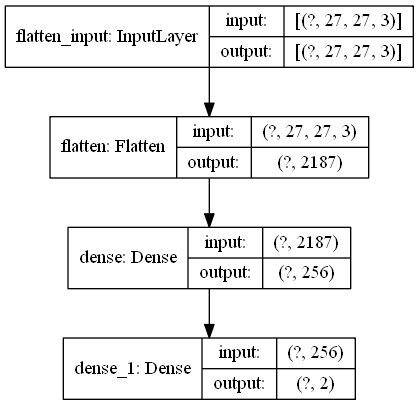

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compiling the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

- **Loss function**: This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
- **Optimizer**: This is how the model is updated based on the data it sees and its loss function.
- **Metrics**: Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.


In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['categorical_accuracy'])

We are using the logarithmic loss function (binary_crossentropy) during training, the preferred loss function for binary classification problems. The model also uses the efficient Adam optimization algorithm for gradient descent and accuracy metrics will be collected when the model is trained.


### Data Loader

As are going to work with much larger and more complicated data set, that neural network are more suited towards, we need to write efficient code to load the data in batches to memory. This is done in keras using Image data generators. 

To help we will define a loading function that takes the data frames we defined earlier:

*It seems that dataloader does not like to read one channel images. It automatically converts them to 3-channel images. Lets ignore this for now.* 

We can use the `flow_from_dataframe` function in the keras data loader to load a set of images directly from a pandas data frame (the data frame should contain the image names (path) and the labels)

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 12168 classes.
Found 4056 validated image filenames belonging to 4056 classes.


With this, the training the validation data can be loaded.
You will need to supply the appropriate directory. Usually each pixels varies from 0-255, but it's highly recommended to normalize them in range of 0-1 to speed up the training process.
The dataloader also do a simple normalisation on the pixel values directly.

Now we can use a simple model.fit\_generator() in Keras to train the model. 

### Model Training
Next we can train the model. The training is done in the fit function. Since we have already setup a data generator, we can use the fit_generator to do the training. 

In [38]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

InvalidArgumentError:  Incompatible shapes: [32,12168] vs. [32,2]
	 [[node gradient_tape/binary_crossentropy/mul_1/BroadcastGradientArgs (defined at <ipython-input-33-44b37581e35a>:1) ]] [Op:__inference_train_function_2223]

Function call stack:
train_function
